In [1]:
%pylab inline
%tensorflow_version 2.x

Populating the interactive namespace from numpy and matplotlib
TensorFlow 2.x selected.


In [0]:
import torch
from torch import nn
from torch import optim

from torchvision.datasets import MNIST

from fastai.basics import *
from fastai.vision import *
from fastai.datasets import *

In [3]:
mnist = MNIST('.', download=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


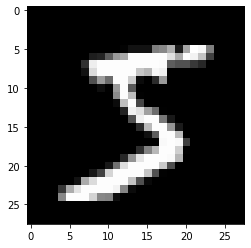

In [4]:
imshow(mnist.train_data[0].detach().numpy(), cmap=cm.gray)

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 64, 2, 1),
            nn.Conv2d(64, 128, 2, 1),
            nn.LeakyReLU(inplace=0.5),
            nn.BatchNorm2d(128)
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(128, 64, 2, 2),
            nn.Conv2d(64, 2, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(1)
        )

        self.fc = nn.Linear(72, 10)

    def forward(self, x):
        x =  self.conv0(x)
        x = self.conv1(x)
        # print(x.shape)
        x = torch.flatten(x,start_dim=1)
        return self.fc(x)

In [6]:
model = Model()
out = model(torch.randn(1, 1, 28, 28))
out.shape

torch.Size([1, 10])

In [7]:
class Data(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x.unsqueeze(1).float()
        self.y = y.long()
    def __getitem__(self, n):
        return self.x[n], self.y[n]

    def __len__(self):
        return self.y.shape[0]

train_data = (mnist.train_data - mnist.train_data.float().mean())/mnist.train_data.float().std()
valid_data = (mnist.test_data - mnist.train_data.float().mean())/mnist.train_data.float().std()

train = Data(
    train_data,
    mnist.train_labels
    )

valid = Data(
    valid_data,
    mnist.test_labels
    )
train[:9][0].shape

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([9, 1, 28, 28])

In [0]:
datab = DataBunch.create(train_ds=train, valid_ds=valid)

In [0]:
trainer = Learner(data=datab, model=model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy]).mixup()

In [10]:
trainer.fit_one_cycle(cyc_len=8, wd=2)

epoch,train_loss,valid_loss,accuracy,time
0,0.777505,0.309490,0.927350,00:13
1,0.792205,0.289667,0.926783,00:13
2,0.769484,0.295163,0.926117,00:13
3,0.761684,0.234611,0.935933,00:13
4,0.766485,0.284238,0.936450,00:13
5,0.729576,0.237606,0.937933,00:13
6,0.692412,0.193409,0.949267,00:13
7,0.674816,0.185463,0.954133,00:13


In [11]:
torch.save(model, 'model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
%%capture

!pip install captum

In [0]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

In [38]:
ex_data, ex_label = valid[1]
inpt = ex_data.unsqueeze(0).cuda()
out = torch.softmax(model(inpt), dim=1).cpu()
pred_score, pred = torch.topk(out, 1)
print(f'{pred_score}, {pred}')



tensor([[0.9949]], grad_fn=<TopkBackward>), tensor([[0]])


In [0]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(inpt, target=pred.squeeze(), n_steps=200)

In [43]:
inpt.squeeze().shape

torch.Size([28, 28])

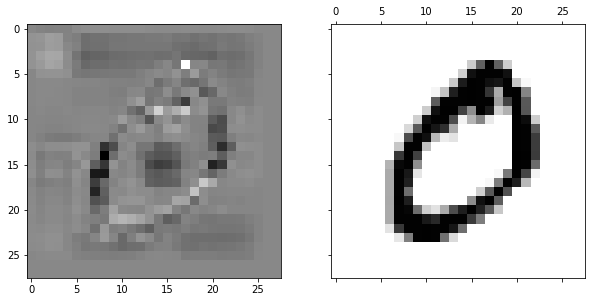

In [62]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 20), sharey=True)

ax0.imshow(attributions_ig.squeeze().cpu().detach().numpy(), cmap=cm.gray_r)
ax1.matshow(inpt.squeeze().cpu().detach().numpy(), cmap=cm.gray_r)

In [0]:
model_anl = nn.Sequential(
    *flatten_model(model)[:-1],
    nn.Flatten()
)

In [64]:
model_anl

Sequential(
  (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
  (1): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (5): Conv2d(64, 2, kernel_size=(2, 2), stride=(2, 2))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten()
)

In [65]:
model_anl(valid[:3][0].cuda()).shape

torch.Size([3, 72])

In [0]:
%%capture
!pip install tensorboardX

In [0]:
from tensorboardX import SummaryWriter

In [68]:
len(valid)

60000

In [0]:
writer = SummaryWriter(log_dir='./log')

In [77]:
inpt, label_orig_t = valid[:500]
mat = model_anl(inpt.cuda())

label_pred_t = model(inpt.cuda()).argmax(axis=1)
images = mnist.test_data[:500]

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [108]:
model_anl(inpt.cuda()).shape, inpt.flatten(1).shape

(torch.Size([500, 72]), torch.Size([500, 784]))

In [82]:
label_orig_l = list(map(str, label_orig_t.detach().tolist()))
label_pred_l = list(map(str, label_orig_t.detach().cpu().tolist()))
label_orig_l[:3], label_pred_l[:3]

(['5', '0', '4'], ['5', '0', '4'])

In [83]:
images.shape

torch.Size([500, 28, 28])

In [0]:
writer.add_embedding(mat=mat, label_img=images.unsqueeze(1), tag="transformed")
writer.add_embedding(mat=inpt.flatten(1), label_img=images.unsqueeze(1), tag="original")

In [0]:
import pandas as pd

df = pd.DataFrame({'original': label_orig_l, 'predict': label_pred_l})
df.to_csv('metadata.tsv', sep='\t', index=False)